## Introduction

In [1]:
# import modules
import sys
import os
import numpy as np
import pandas as pd
import serpentTools
from matplotlib import rc
# from uncertainties import ufloat, unumpy

# add "coremap" directories to path
coremapath = 'C:\\Users\\39346\\Documents\\mycodes\\coreutils\\coremap'
sys.path.append(coremapath)
from CoreMap import CoreMap, uncformat
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200  # set dpi for increasing plot rendering quality
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# for Palatino and other serif fonts use:
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
rc('text', usetex=True)

# input file name and location
fname = 'alfred_1_6.txt'

# define geometrical parameters
L = 17.1  # pitch [cm]
rotangle = 60  # rotation angle [degree]

# instance initialisation
core = CoreMap(fname, rotangle, L)

The assembly numeration follows the one employed in the FRENETIC code, according to which the hexagonal core is divided in six sextant counter-clockwise-sorted.

C:\Users\39346\Documents\mycodes\coreutils\coremap\CoreMap.py:514: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  fill=fill, **kwargs)


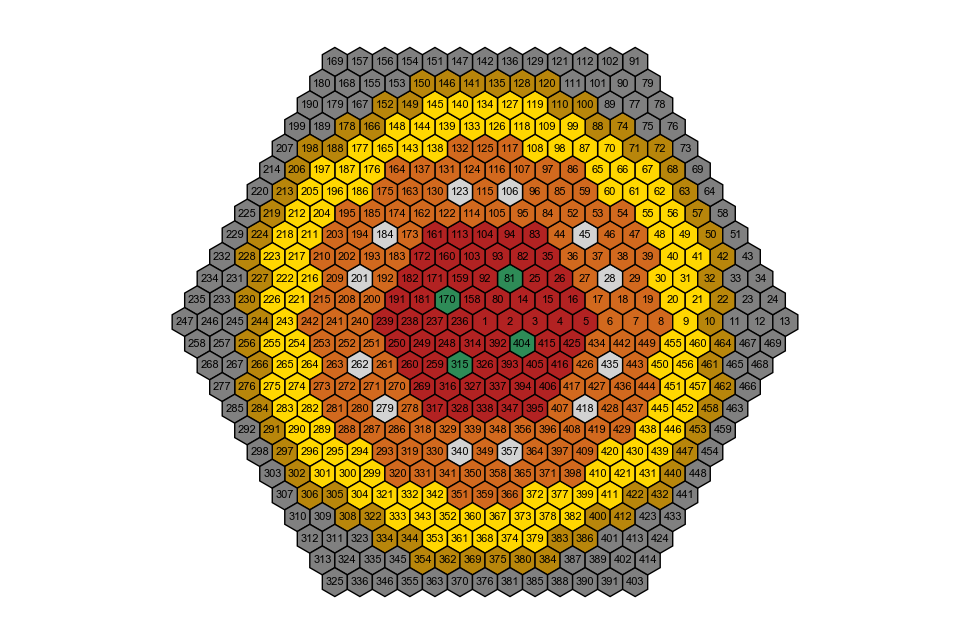

In [2]:
# load ALFRED's safety rods
SR_fren_position = [81, 315, 170, 404]  # assemblies to be perturbed
SR_type = [5]  # new assembly type
core.loadassembly(SR_type, SR_fren_position, flagfren=True)

# plot new geometry without any label
core.plot(label=True, fren=True, scale=5) 

According to the FRENETIC numeration, the detectors are placed along some cuts, depicted in the following.

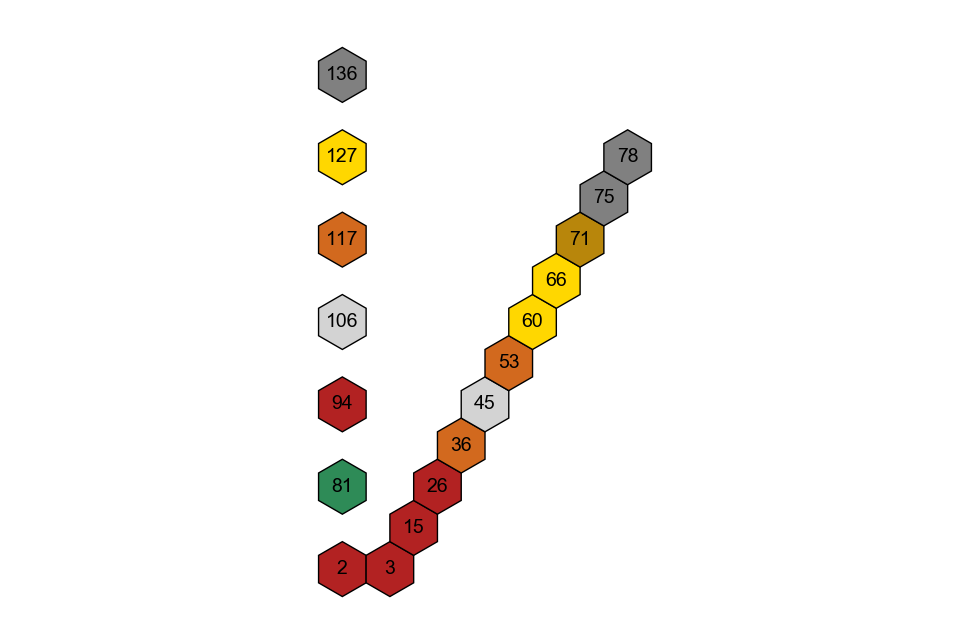

In [3]:
cut1 = [2, 81, 94, 106, 117, 127, 136]
cut2 = [3, 15, 26, 36, 45, 53, 60, 66, 71, 75, 78]
cuts = [*cut1, *cut2]
# plot only selected assemblies
core.plot(label=True, which=[*cut1, *cut2], fren=True, fontsize=7)

## Serpent detector results analysis
Two sets of respectively 3 and 17 cm wide tallies were defined in the Monte Carlo simulation:
* *power* tally to monitor the total fission power deposited in the fuel assemblies, neglecting the heat contribution due to the neutron KERMA and to the photon deposition. The axial coordinate ranges from -60 cm up to 60 cm, where the core midplace is placed at 0 cm.
* *one-group flux* tally to evaluate the mono-energetic flux tallied inside the whole core. The axial coordinate ranges from -170 cm up to 170 cm, where the core midplace is placed at 0 cm.

The Serpent output is read and processed with the serpentTools package (https://github.com/CORE-GATECH-GROUP/serpent-tools).

In [4]:
# Serpent (v 2.1.31) output path
# read Serpent output file with serpentTools
H = 3  # axial bin width
datapath = 'C:\\Users\\39346\\Desktop\\ricerca\\sarotto\\traverse\\%gcm' % H
fname = os.path.join(datapath, "ALFRED_FC_HFP_det0.m")
alfred = serpentTools.read(fname)

# take useful detectors
POW = alfred.detectors['POW']
FLX = alfred.detectors['FLX']

# take geometry feature
Nz, Nx, Ny = POW.tallies.shape
zcoord = POW.grids['Z']

# workaround to fix Serpent-2 numeration bug
assnum = np.arange(2+Nx, Nx*Ny+2+Nx)

# select Serpent assemblies matching cuts
serpcuts = np.asarray([core.fren2serp[k]+Nx+1 for k in cuts])

### Power tally

In [5]:
# preallocations
dataset_mean = np.empty((Nz, len(cuts)))
dataset_std = np.empty((Nz, len(cuts)))
val = []
valappend = val.append
# reshape dataset 
for iZ, z in enumerate(zcoord):
    # slice results
    tallies = POW.tallies[iZ, :, :]
    errors = POW.errors[iZ, :, :]
    # try to plot physics
    tallies = tallies/1e3  # power in MW
    # flattening sq. or hex. lattice by rows
    tallies = tallies.flatten('C')
    # define standard deviation coming from Serpent
    errors = 2*errors.flatten('C')
    # extract assemblies belonging to cut1 and cut2
    mean = list(tallies[serpcuts])
    std = list(errors[serpcuts])
    # define uncertain array
    x = uncformat(mean, std, fmtn=".1f", fmts="%.2f") #unumpy.uarray(mean, std)
    valappend(x)
    # check consistency
    # define dict
    tallies = dict(zip(assnum, tallies))
    errors = dict(zip(assnum, errors))
    dataset_mean[iZ, :] = mean
    dataset_std[iZ, :] = std

# convert val to numpy array
val = np.asarray(val)
#pd.set_option('display.float_format', '{:.2eP}'.format)
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)

## 1st cut

In [6]:
# display results of 1st cut
rows = map(lambda z: "z="+str(z)+" [cm]", zcoord[:,2])
df1 = pd.DataFrame(val[:, 0:len(cut1)], columns=cut1, index=list(rows))
display(df1)

2            81         94          106        117  \
z=-28.5 [cm]  0.0±0.00%   72.8±0.69%  0.0±0.00%  50.5±0.92%  0.0±0.00%   
z=-25.5 [cm]  0.0±0.00%   80.2±0.65%  0.0±0.00%  56.4±0.92%  0.0±0.00%   
z=-22.5 [cm]  0.0±0.00%   87.2±0.65%  0.0±0.00%  62.3±0.76%  0.0±0.00%   
z=-19.5 [cm]  0.0±0.00%   94.1±0.65%  0.0±0.00%  69.0±0.70%  0.0±0.00%   
z=-16.5 [cm]  0.0±0.00%  101.0±0.61%  0.0±0.00%  74.0±0.65%  0.0±0.00%   
z=-13.5 [cm]  0.0±0.00%  106.9±0.53%  0.0±0.00%  78.7±0.67%  0.0±0.00%   
z=-10.5 [cm]  0.0±0.00%  113.1±0.54%  0.0±0.00%  83.0±0.67%  0.0±0.00%   
z=-7.5 [cm]   0.0±0.00%  116.9±0.52%  0.0±0.00%  86.0±0.64%  0.0±0.00%   
z=-4.5 [cm]   0.0±0.00%  119.9±0.53%  0.0±0.00%  88.8±0.67%  0.0±0.00%   
z=-1.5 [cm]   0.0±0.00%  121.9±0.51%  0.0±0.00%  90.2±0.64%  0.0±0.00%   
z=1.5 [cm]    0.0±0.00%  122.8±0.48%  0.0±0.00%  91.4±0.69%  0.0±0.00%   
z=4.5 [cm]    0.0±0.00%  122.1±0.49%  0.0±0.00%  91.4±0.66%  0.0±0.00%   
z=7.5 [cm]    0.0±0.00%  120.8±0.52%  0.0±0.00%  90.7±0.66%  0.0±0.00%   
z=10.5 [cm]   0.0±0.00%  117.9±0.53%  0.0±0.00%  89.4±0.64%  0.0±0.00%   
z=13.5 [cm]   0.0±0.00%  114.7±0.55%  0.0±0.00%  86.8±0.52%  0.0±0.00%   
z=16.5 [cm]   0.0±0.00%  110.8±0.55%  0.0±0.00%  83.9±0.67%  0.0±0.00%   
z=19.5 [cm]   0.0±0.00%  105.4±0.54%  0.0±0.00%  80.4±0.65%  0.0±0.00%   
z=22.5 [cm]   0.0±0.00%  100.4±0.60%  0.0±0.00%  76.6±0.67%  0.0±0.00%   
z=25.5 [cm]   0.0±0.00%   95.4±0.56%  0.0±0.00%  73.6±0.86%  0.0±0.00%   
z=28.5 [cm]   0.0±0.00%   93.9±0.70%  0.0±0.00%  73.2±0.96%  0.0±0.00%   

                    127        136  
z=-28.5 [cm]  0.0±0.00%  0.0±0.00%  
z=-25.5 [cm]  0.0±0.00%  0.0±0.00%  
z=-22.5 [cm]  0.0±0.00%  0.0±0.00%  
z=-19.5 [cm]  0.0±0.00%  0.0±0.00%  
z=-16.5 [cm]  0.0±0.00%  0.0±0.00%  
z=-13.5 [cm]  0.0±0.00%  0.0±0.00%  
z=-10.5 [cm]  0.0±0.00%  0.0±0.00%  
z=-7.5 [cm]   0.0±0.00%  0.0±0.00%  
z=-4.5 [cm]   0.0±0.00%  0.0±0.00%  
z=-1.5 [cm]   0.0±0.00%  0.0±0.00%  
z=1.5 [cm]    0.0±0.00%  0.0±0.00%  
z=4.5 [cm]    0.0±0.00%  0.0±0.00%  
z=7.5 [cm]    0.0±0.00%  0.0±0.00%  
z=10.5 [cm]   0.0±0.00%  0.0±0.00%  
z=13.5 [cm]   0.0±0.00%  0.0±0.00%  
z=16.5 [cm]   0.0±0.00%  0.0±0.00%  
z=19.5 [cm]   0.0±0.00%  0.0±0.00%  
z=22.5 [cm]   0.0±0.00%  0.0±0.00%  
z=25.5 [cm]   0.0±0.00%  0.0±0.00%  
z=28.5 [cm]   0.0±0.00%  0.0±0.00%

## 2nd cut

In [7]:
# display results of 2nd cut
rows = map(lambda z: "z="+str(z)+" [cm]", zcoord[:,2])
df2 = pd.DataFrame(val[:, len(cut1):len(cuts)], columns=cut2, index=list(rows))
display(df2)

3           15          26         36         45  \
z=-28.5 [cm]  52.6±0.90%  53.8±0.96%  51.2±1.12%  0.0±0.00%  0.0±0.00%   
z=-25.5 [cm]  57.1±0.73%  56.2±0.76%  51.2±0.99%  0.0±0.00%  0.0±0.00%   
z=-22.5 [cm]  62.8±0.68%  60.1±0.78%  54.0±1.00%  0.0±0.00%  0.0±0.00%   
z=-19.5 [cm]  68.4±0.66%  64.4±0.68%  57.3±0.80%  0.0±0.00%  0.0±0.00%   
z=-16.5 [cm]  73.6±0.59%  69.0±0.68%  59.9±0.89%  0.0±0.00%  0.0±0.00%   
z=-13.5 [cm]  77.7±0.70%  72.2±0.66%  63.2±0.79%  0.0±0.00%  0.0±0.00%   
z=-10.5 [cm]  81.8±0.61%  76.2±0.73%  65.6±0.79%  0.0±0.00%  0.0±0.00%   
z=-7.5 [cm]   85.0±0.58%  78.3±0.68%  67.2±0.77%  0.0±0.00%  0.0±0.00%   
z=-4.5 [cm]   87.3±0.67%  80.7±0.76%  68.9±0.86%  0.0±0.00%  0.0±0.00%   
z=-1.5 [cm]   88.6±0.62%  81.5±0.74%  70.1±0.76%  0.0±0.00%  0.0±0.00%   
z=1.5 [cm]    89.4±0.61%  82.1±0.69%  70.7±0.65%  0.0±0.00%  0.0±0.00%   
z=4.5 [cm]    89.3±0.66%  81.5±0.66%  70.6±0.84%  0.0±0.00%  0.0±0.00%   
z=7.5 [cm]    88.3±0.68%  81.4±0.66%  69.7±0.80%  0.0±0.00%  0.0±0.00%   
z=10.5 [cm]   86.6±0.66%  79.9±0.68%  68.5±0.81%  0.0±0.00%  0.0±0.00%   
z=13.5 [cm]   84.6±0.71%  77.3±0.74%  66.9±0.87%  0.0±0.00%  0.0±0.00%   
z=16.5 [cm]   82.2±0.69%  74.8±0.79%  64.5±0.81%  0.0±0.00%  0.0±0.00%   
z=19.5 [cm]   78.8±0.77%  71.9±0.70%  61.9±0.92%  0.0±0.00%  0.0±0.00%   
z=22.5 [cm]   74.8±0.74%  68.9±0.83%  58.9±0.91%  0.0±0.00%  0.0±0.00%   
z=25.5 [cm]   71.8±0.82%  65.9±0.83%  57.5±0.91%  0.0±0.00%  0.0±0.00%   
z=28.5 [cm]   72.3±0.86%  66.6±0.87%  58.9±0.98%  0.0±0.00%  0.0±0.00%   

                     53         60         66         71         75         78  
z=-28.5 [cm]  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=-25.5 [cm]  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=-22.5 [cm]  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=-19.5 [cm]  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=-16.5 [cm]  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=-13.5 [cm]  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=-10.5 [cm]  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=-7.5 [cm]   0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=-4.5 [cm]   0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=-1.5 [cm]   0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=1.5 [cm]    0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=4.5 [cm]    0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=7.5 [cm]    0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=10.5 [cm]   0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=13.5 [cm]   0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=16.5 [cm]   0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=19.5 [cm]   0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=22.5 [cm]   0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=25.5 [cm]   0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  
z=28.5 [cm]   0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%  0.0±0.00%

### Flux tally

In [8]:
# compute tally volume
zcoord = FLX.grids['Z']
H_FLX = 340/len(zcoord)
core.assembly.compute_volume(H_FLX)

# preallocations
dataset_mean = np.empty((Nz, len(cuts)))
dataset_std = np.empty((Nz, len(cuts)))
val = []
valappend = val.append
peak_factor = np.max(np.max(FLX.tallies))

# reshape dataset 
for iZ, z in enumerate(zcoord):
    # slice results
    tallies = FLX.tallies[iZ, :, :]
    errors = FLX.errors[iZ, :, :]
    # try to plot physics
    # flattening sq. or hex. lattice by rows
    tallies = tallies.flatten('C')
    # define standard deviation coming from Serpent
    errors = 2*errors.flatten('C')
    # extract assemblies belonging to cut1 and cut2
    mean = list(tallies[serpcuts])
    std = list(errors[serpcuts])
    # define uncertain array
    x = uncformat(mean, std, fmtn=".2E", fmts='%.2f') #unumpy.uarray(mean, std)
    valappend(x)
    # check consistency
    # define dict
    tallies = dict(zip(assnum, tallies))
    errors = dict(zip(assnum, errors))
    dataset_mean[iZ, :] = mean
    dataset_std[iZ, :] = std

# convert val to numpy array
val = np.asarray(val)
#pd.set_option('display.float_format', '{:.2eP}'.format)
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)

# define rows label
rows = map(lambda z: "z="+str(z)+" [cm]", zcoord[:,2]) #zip("z="*len(zcoord), zcoord[:,2])

### 1st cut

In [9]:
# display results of 1st cut
df1 = pd.DataFrame(val[:, 0:len(cut1)], columns=cut1, index=list(rows))
display(df1)

2               81              94              106  \
z=-160.0 [cm]  3.93E+16±4.08%  4.31E+16±3.52%  3.91E+16±4.12%  2.76E+16±5.06%   
z=-140.0 [cm]  1.15E+17±2.51%  1.35E+17±2.11%  1.16E+17±2.57%  8.33E+16±3.17%   
z=-120.0 [cm]  2.04E+17±1.98%  2.76E+17±1.67%  2.02E+17±1.85%  1.55E+17±2.20%   
z=-100.0 [cm]  1.51E+17±1.43%  5.32E+17±1.19%  1.50E+17±1.35%  2.35E+17±1.55%   
z=-80.0 [cm]   2.14E+17±0.88%  1.02E+18±0.81%  2.12E+17±0.84%  4.64E+17±1.07%   
z=-60.0 [cm]   4.61E+17±0.54%  1.85E+18±0.66%  4.62E+17±0.64%  9.49E+17±0.79%   
z=-40.0 [cm]   1.45E+18±0.42%  3.42E+18±0.44%  1.46E+18±0.39%  2.06E+18±0.56%   
z=-20.0 [cm]   5.82E+18±0.31%  6.58E+18±0.33%  5.80E+18±0.33%  4.65E+18±0.38%   
z=0.0 [cm]     7.96E+18±0.32%  8.65E+18±0.31%  7.92E+18±0.32%  6.28E+18±0.37%   
z=20.0 [cm]    6.86E+18±0.26%  7.34E+18±0.28%  6.85E+18±0.34%  5.42E+18±0.40%   
z=40.0 [cm]    4.37E+18±0.40%  4.67E+18±0.37%  4.35E+18±0.47%  3.56E+18±0.47%   
z=60.0 [cm]    2.61E+18±0.57%  2.75E+18±0.50%  2.61E+18±0.52%  2.15E+18±0.58%   
z=80.0 [cm]    1.37E+18±0.77%  1.42E+18±0.73%  1.37E+18±0.74%  1.14E+18±0.68%   
z=100.0 [cm]   6.55E+17±1.16%  6.65E+17±0.87%  6.57E+17±1.08%  5.52E+17±1.29%   
z=120.0 [cm]   2.77E+17±1.52%  2.86E+17±1.59%  2.73E+17±1.57%  2.40E+17±1.78%   
z=140.0 [cm]   1.09E+17±2.59%  1.10E+17±2.63%  1.07E+17±2.81%  9.17E+16±2.78%   
z=160.0 [cm]   3.03E+16±4.72%  3.01E+16±4.39%  2.96E+16±5.01%  2.50E+16±4.97%   

                          117             127              136  
z=-160.0 [cm]  1.95E+16±5.66%  1.08E+16±8.04%  4.46E+15±12.76%  
z=-140.0 [cm]  5.89E+16±3.81%  3.42E+16±4.92%   1.39E+16±7.37%  
z=-120.0 [cm]  1.25E+17±2.70%  7.16E+16±3.40%   2.86E+16±4.28%  
z=-100.0 [cm]  2.45E+17±1.72%  1.34E+17±2.62%   5.19E+16±3.43%  
z=-80.0 [cm]   5.10E+17±1.22%  2.63E+17±1.54%   9.74E+16±2.77%  
z=-60.0 [cm]   1.01E+18±0.78%  5.09E+17±1.24%   1.77E+17±2.12%  
z=-40.0 [cm]   1.88E+18±0.64%  8.81E+17±0.94%   2.91E+17±1.48%  
z=-20.0 [cm]   3.12E+18±0.49%  1.33E+18±0.82%   4.09E+17±1.43%  
z=0.0 [cm]     3.90E+18±0.41%  1.58E+18±0.66%   4.78E+17±1.30%  
z=20.0 [cm]    3.44E+18±0.39%  1.49E+18±0.74%   4.75E+17±1.34%  
z=40.0 [cm]    2.38E+18±0.60%  1.17E+18±0.94%   4.05E+17±1.41%  
z=60.0 [cm]    1.46E+18±0.67%  7.52E+17±0.97%   2.89E+17±1.78%  
z=80.0 [cm]    7.81E+17±0.92%  4.21E+17±1.34%   1.78E+17±2.14%  
z=100.0 [cm]   3.84E+17±1.35%  2.13E+17±1.94%   1.00E+17±2.86%  
z=120.0 [cm]   1.72E+17±2.12%  9.82E+16±2.80%   4.83E+16±4.14%  
z=140.0 [cm]   6.97E+16±3.27%  4.08E+16±4.45%   2.11E+16±7.04%  
z=160.0 [cm]   1.97E+16±6.33%  1.08E+16±7.60%   5.97E+15±9.90%

### 2nd cut

In [10]:
# display results of 2nd cut
rows = map(lambda z: "z="+str(z)+" [cm]", zcoord[:,2])
df2 = pd.DataFrame(val[:, len(cut1):len(cuts)], columns=cut2, index=list(rows))
display(df2)

3               15              26              36  \
z=-160.0 [cm]  2.82E+16±5.45%  2.67E+16±4.78%  2.32E+16±5.61%  1.78E+16±5.53%   
z=-140.0 [cm]  8.35E+16±3.19%  8.21E+16±3.24%  7.28E+16±3.30%  5.56E+16±3.54%   
z=-120.0 [cm]  1.58E+17±2.08%  1.66E+17±2.18%  1.50E+17±2.02%  1.20E+17±2.57%   
z=-100.0 [cm]  2.60E+17±1.55%  3.24E+17±1.52%  3.08E+17±1.56%  2.35E+17±1.78%   
z=-80.0 [cm]   5.29E+17±1.18%  6.81E+17±1.03%  6.53E+17±1.07%  4.91E+17±1.24%   
z=-60.0 [cm]   1.05E+18±0.78%  1.30E+18±0.71%  1.23E+18±0.79%  9.62E+17±0.98%   
z=-40.0 [cm]   2.15E+18±0.51%  2.36E+18±0.58%  2.14E+18±0.60%  1.70E+18±0.66%   
z=-20.0 [cm]   4.54E+18±0.39%  4.25E+18±0.38%  3.57E+18±0.46%  2.68E+18±0.53%   
z=0.0 [cm]     6.05E+18±0.37%  5.52E+18±0.42%  4.53E+18±0.43%  3.28E+18±0.51%   
z=20.0 [cm]    5.21E+18±0.36%  4.72E+18±0.43%  3.89E+18±0.47%  2.92E+18±0.51%   
z=40.0 [cm]    3.44E+18±0.45%  3.13E+18±0.44%  2.65E+18±0.56%  2.05E+18±0.57%   
z=60.0 [cm]    2.10E+18±0.59%  1.91E+18±0.60%  1.63E+18±0.66%  1.29E+18±0.80%   
z=80.0 [cm]    1.11E+18±0.84%  1.01E+18±0.84%  8.67E+17±0.91%  7.00E+17±1.07%   
z=100.0 [cm]   5.30E+17±1.19%  4.85E+17±1.29%  4.18E+17±1.27%  3.40E+17±1.49%   
z=120.0 [cm]   2.30E+17±1.57%  2.10E+17±1.90%  1.83E+17±2.16%  1.53E+17±2.12%   
z=140.0 [cm]   8.95E+16±2.69%  8.34E+16±2.89%  7.37E+16±3.15%  6.09E+16±3.79%   
z=160.0 [cm]   2.52E+16±4.54%  2.24E+16±5.86%  2.01E+16±5.84%  1.74E+16±6.19%   

                           45              53               60  \
z=-160.0 [cm]  1.27E+16±7.74%  7.52E+15±8.94%  4.08E+15±14.26%   
z=-140.0 [cm]  3.87E+16±4.40%  2.61E+16±5.33%   1.26E+16±6.72%   
z=-120.0 [cm]  8.48E+16±2.76%  5.27E+16±3.87%   2.69E+16±4.86%   
z=-100.0 [cm]  1.61E+17±2.36%  9.91E+16±2.89%   4.98E+16±3.83%   
z=-80.0 [cm]   3.16E+17±1.57%  1.88E+17±1.73%   9.25E+16±2.98%   
z=-60.0 [cm]   6.22E+17±0.98%  3.69E+17±1.40%   1.78E+17±2.04%   
z=-40.0 [cm]   1.12E+18±0.89%  6.56E+17±1.07%   3.12E+17±1.37%   
z=-20.0 [cm]   1.73E+18±0.66%  9.85E+17±0.89%   4.57E+17±1.24%   
z=0.0 [cm]     2.08E+18±0.51%  1.17E+18±0.84%   5.48E+17±1.21%   
z=20.0 [cm]    1.92E+18±0.60%  1.13E+18±0.85%   5.56E+17±1.10%   
z=40.0 [cm]    1.45E+18±0.71%  9.16E+17±0.94%   4.77E+17±1.13%   
z=60.0 [cm]    9.31E+17±0.93%  6.01E+17±1.17%   3.26E+17±1.64%   
z=80.0 [cm]    5.15E+17±1.36%  3.50E+17±1.57%   1.94E+17±1.98%   
z=100.0 [cm]   2.57E+17±1.73%  1.76E+17±2.28%   9.96E+16±2.40%   
z=120.0 [cm]   1.16E+17±2.60%  8.16E+16±2.95%   4.65E+16±4.20%   
z=140.0 [cm]   4.67E+16±4.16%  3.41E+16±4.94%   1.93E+16±6.17%   
z=160.0 [cm]   1.36E+16±7.37%  9.38E+15±7.94%   6.09E+15±9.82%   

                            66               71               75  \
z=-160.0 [cm]  1.84E+15±18.82%  5.16E+14±23.97%  1.00E+15±17.51%   
z=-140.0 [cm]  4.98E+15±11.60%  1.20E+15±14.61%  1.54E+15±15.77%   
z=-120.0 [cm]   1.03E+16±7.34%  2.31E+15±12.00%   2.63E+15±9.85%   
z=-100.0 [cm]   1.80E+16±5.75%   4.33E+15±9.10%   4.66E+15±8.26%   
z=-80.0 [cm]    3.33E+16±4.59%   7.00E+15±7.54%   7.62E+15±6.47%   
z=-60.0 [cm]    6.25E+16±2.58%   1.32E+16±5.31%   1.26E+16±5.93%   
z=-40.0 [cm]    1.05E+17±2.45%   2.09E+16±4.21%   1.72E+16±4.23%   
z=-20.0 [cm]    1.57E+17±1.97%   2.91E+16±3.73%   2.22E+16±3.96%   
z=0.0 [cm]      1.88E+17±1.58%   3.51E+16±2.94%   2.64E+16±3.43%   
z=20.0 [cm]     1.89E+17±1.81%   3.47E+16±3.05%   2.57E+16±3.63%   
z=40.0 [cm]     1.62E+17±2.03%   3.13E+16±3.28%   2.37E+16±4.39%   
z=60.0 [cm]     1.16E+17±2.68%   2.27E+16±3.17%   1.88E+16±4.19%   
z=80.0 [cm]     7.10E+16±2.77%   1.48E+16±4.91%   1.34E+16±5.46%   
z=100.0 [cm]    3.77E+16±3.40%   8.47E+15±6.58%   8.07E+15±7.66%   
z=120.0 [cm]    1.77E+16±5.21%   4.24E+15±7.78%   4.83E+15±7.19%   
z=140.0 [cm]    7.22E+15±7.82%  1.93E+15±12.62%  2.90E+15±10.16%   
z=160.0 [cm]   2.15E+15±16.74%  6.58E+14±22.07%  1.37E+15±15.52%   

                            78  
z=-160.0 [cm]  1.05E+15±19.22%  
z=-140.0 [cm]  1.74E+15±14.67%  
z=-120.0 [cm]  3.12E+15±10.41%  
z=-100.0 [cm]   4.90E+

### 2D tally power maps

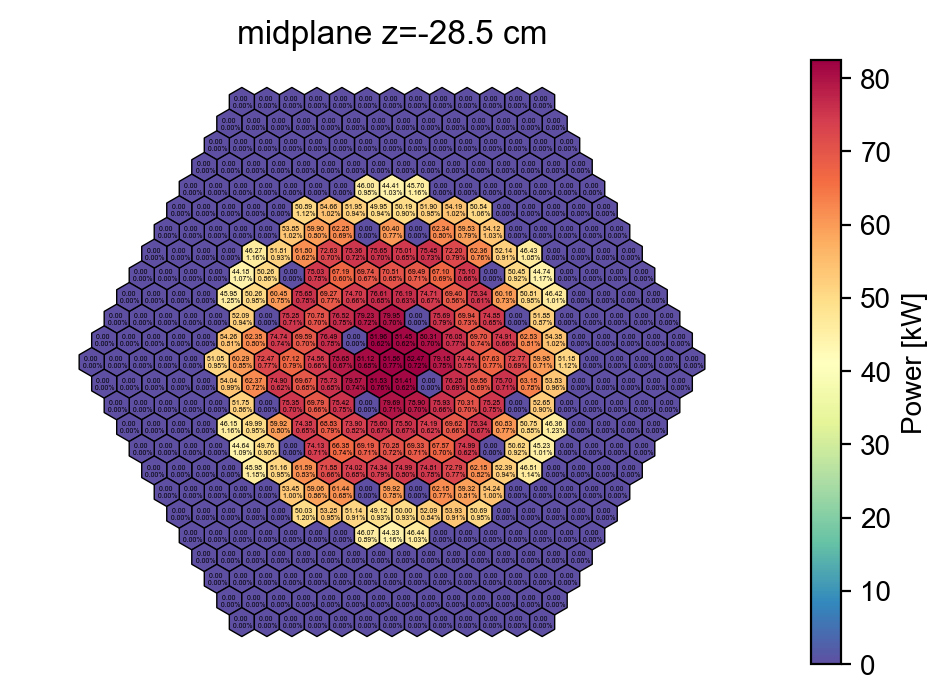

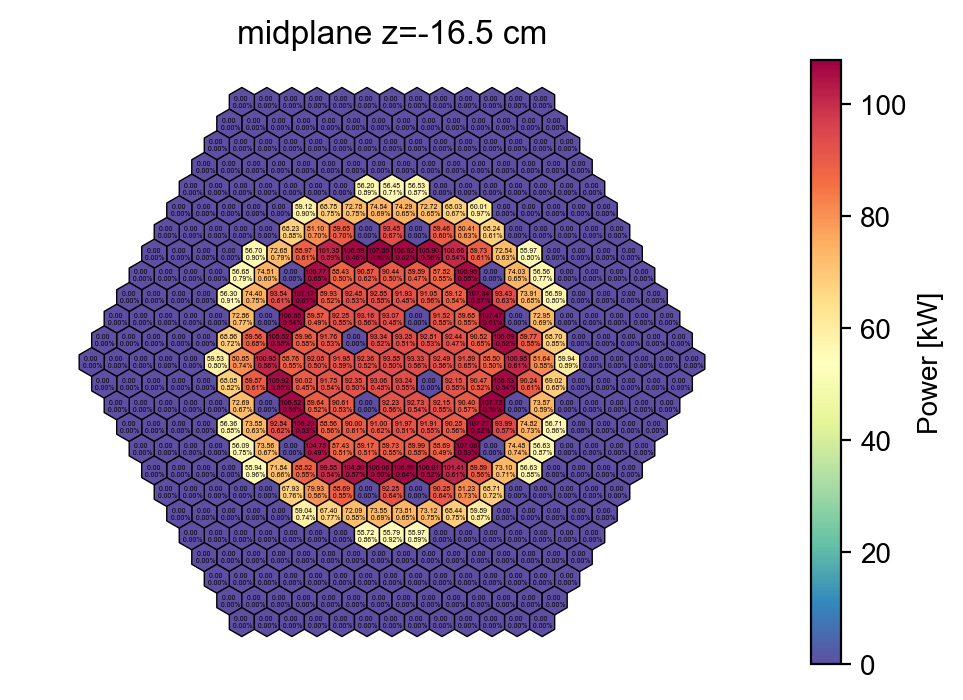

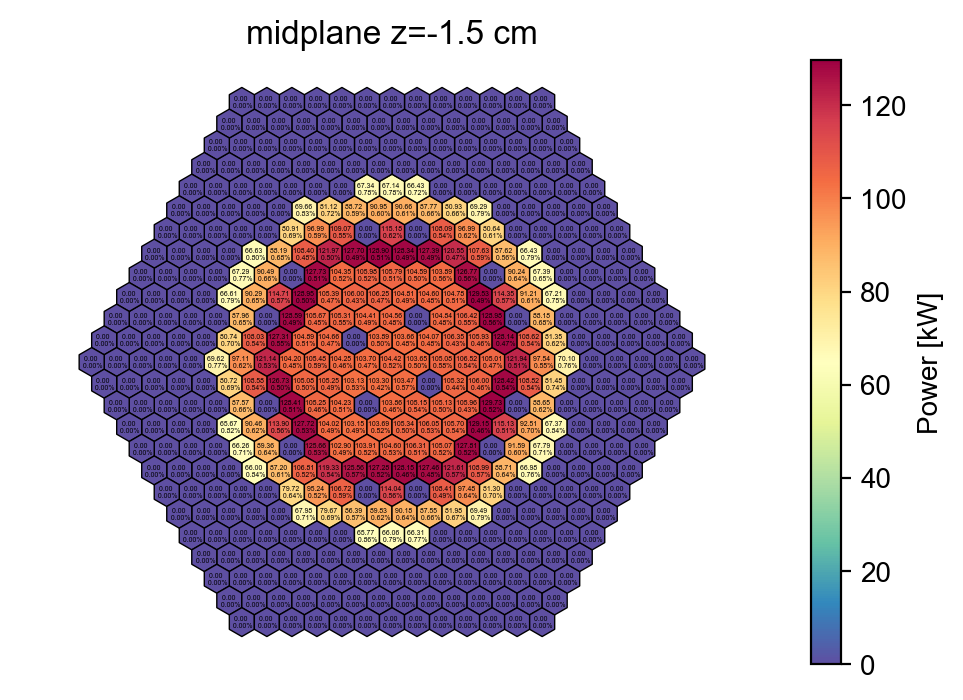

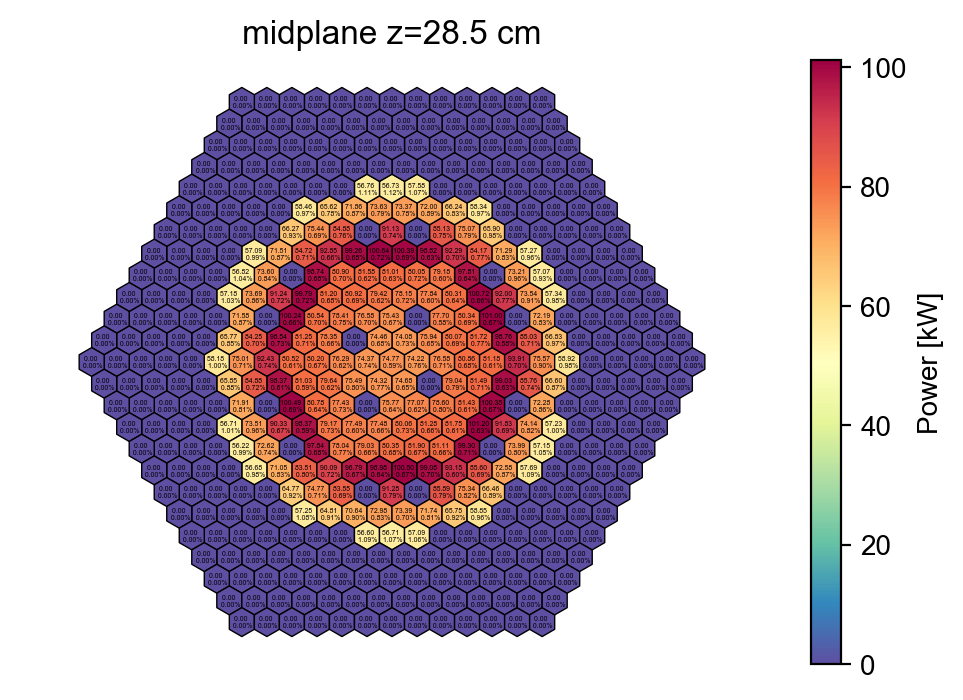

In [11]:
zplot = [0, 4, 9, 19]
for z in zplot:
    tallies = POW.tallies[z, :, :]
    errors = POW.errors[z, :, :]
    # try to plot physics
    tallies_mod = tallies/1e3
    # flattening sq. or hex. lattice by rows
    tallies_mod = tallies_mod.flatten('C')
    errors = 2*(errors.flatten('C'))
    tallies_mod = dict(zip(assnum, tallies_mod))
    errors = dict(zip(assnum, errors))
    core.plot(what={"tallies": tallies_mod, "errors": errors},
          label=True, fren=True, fontsize=2.5,
          cbarLabel="Power [kW]", title="midplane z=%.1f cm" % POW.grids['Z'][z,2])

### 2D tally flux maps
The following maps are plotted normalising the tallies over the peak flux, which is detected within 0 and 17 cm in assembly number 160, according to FRENETIC numeraiton. As expected, due to the statistical noise, the flux in the surrounding assemblies, placed in symmetrical position with respect to assembly 160, is not exactly equal to 1, but it is slighly lower.
The effect of the statistical noise in the flux symmetry is particularly relevant in the outermost tally, which is the farthest from the particle source and which feels the influence due to the safety rods.

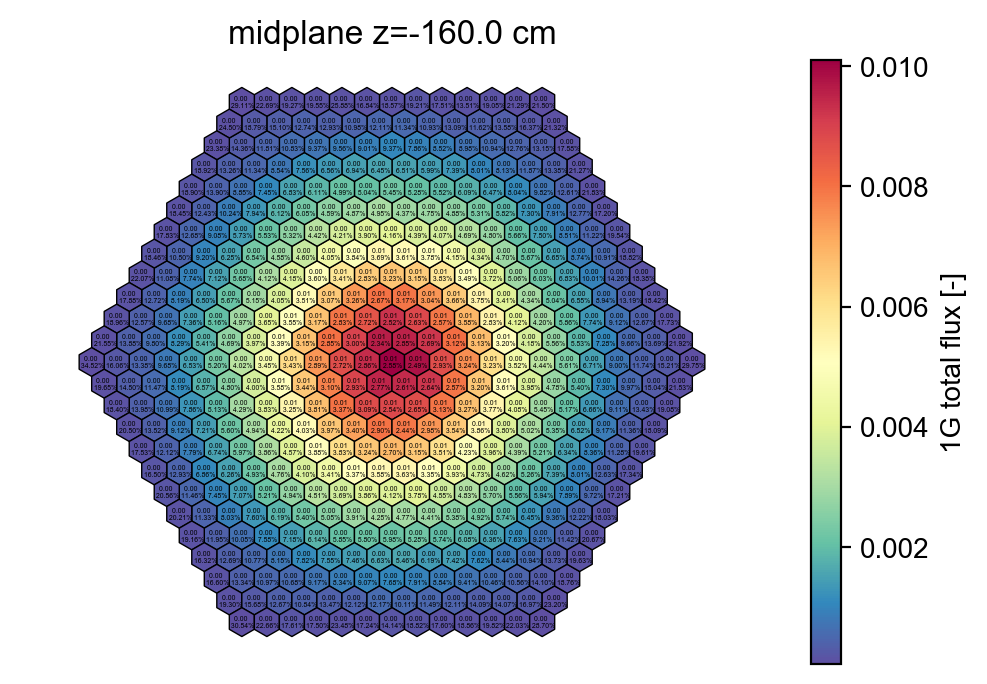

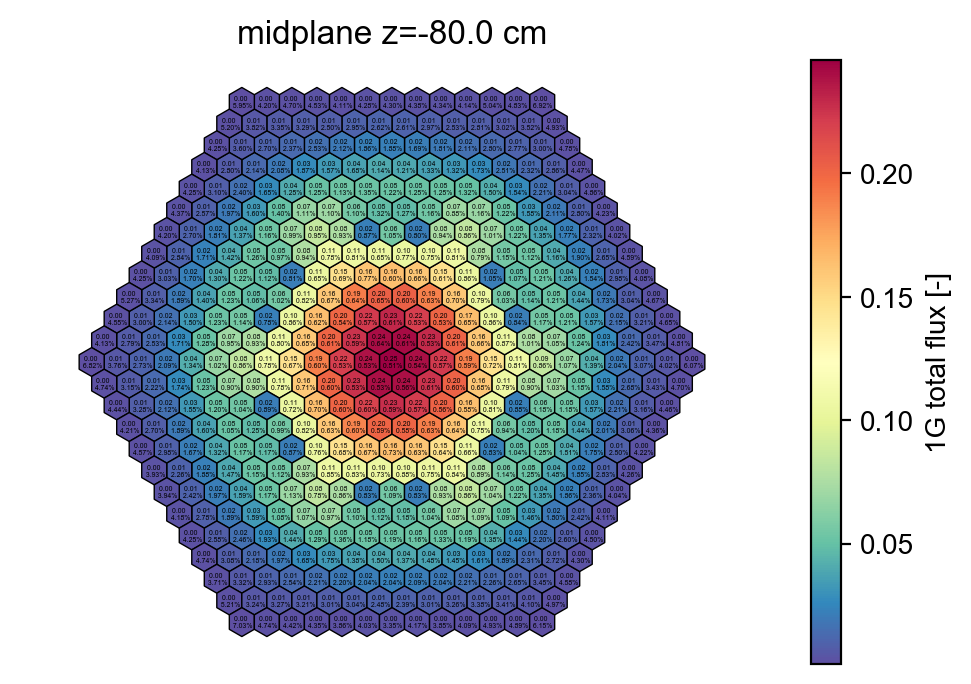

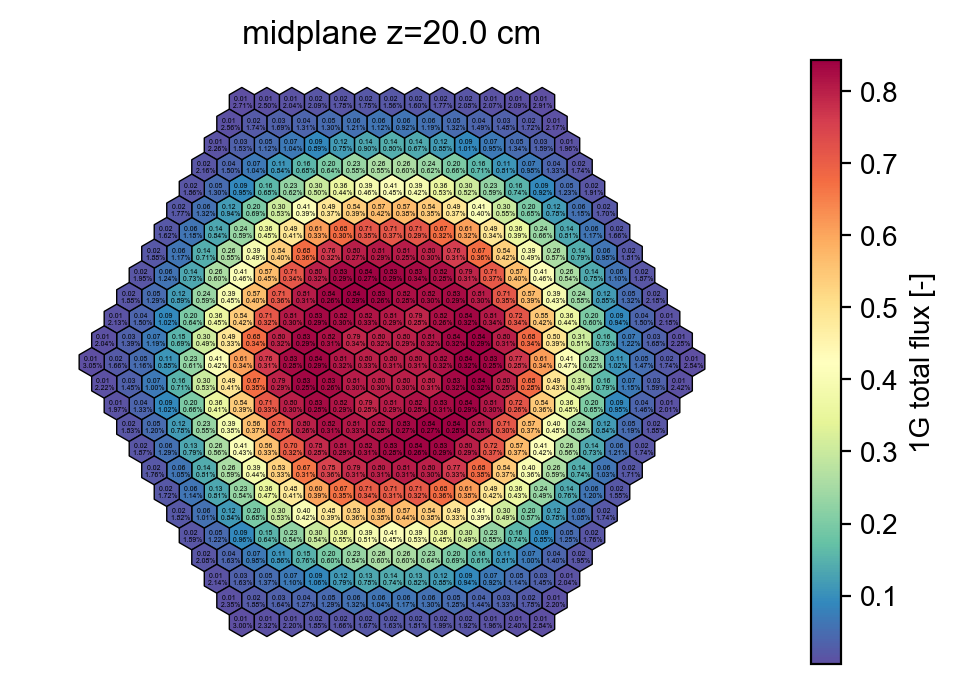

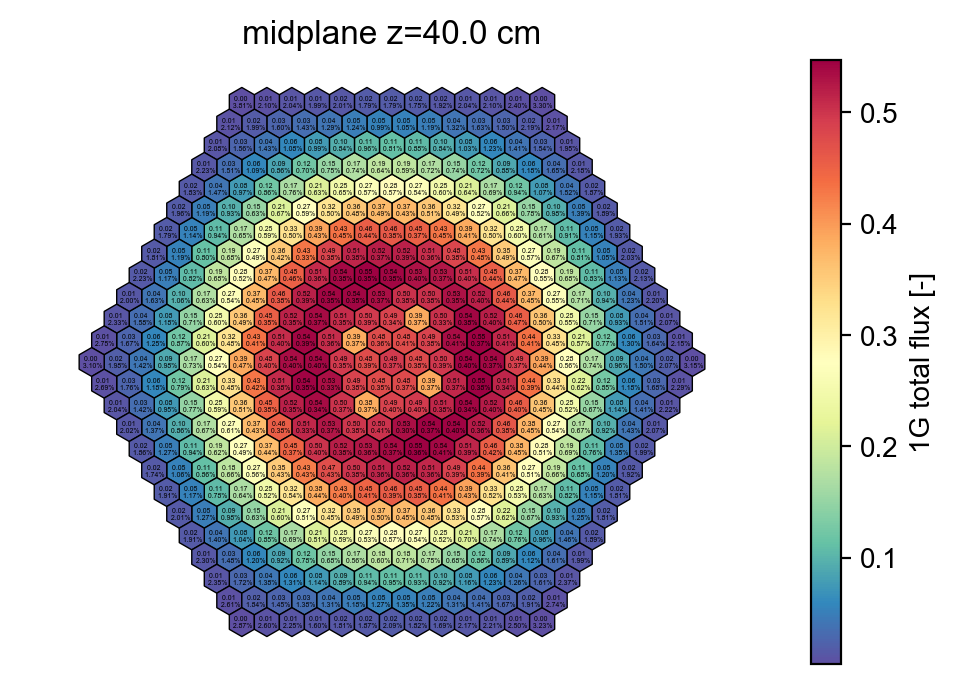

In [14]:
peak_factor = np.max(np.max(FLX.tallies))
zplot = [0, 4, 9, 10, 16]
for z in zplot:
    tallies = FLX.tallies[z, :, :]
    errors = FLX.errors[z, :, :]
    # try to plot physics
    tallies = tallies/peak_factor
    # flattening sq. or hex. lattice by rows
    tallies_mod = tallies.flatten('C')
    errors = 2*errors.flatten('C')
    tallies_mod = dict(zip(assnum, tallies_mod))
    errors = dict(zip(assnum, errors))
    core.plot(what={"tallies": tallies_mod, "errors": errors},
              label=True, fren=True, fontsize=2.5,
              cbarLabel="1G total flux [-]", 
              title="midplane z=%.1f cm" % zcoord[z,2]) # , "errors": errors